In [8]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/Users/rickgentry/Spring 2021/computer_vision/final_project/notebooks'

In [4]:
image_dir = '/Users/rickgentry/Spring 2021/computer_vision/final_project/data/PhotoSorter_images'

In [5]:
filenames = os.listdir(image_dir)


In [6]:
images = [cv2.imread(os.path.join(image_dir,file)) for file in filenames]

In [6]:
images[0].shape

(3024, 4032, 3)

In [7]:
def resize_images(images,size,method=cv2.INTER_LINEAR):
    same_size_images = [cv2.resize(image,size,interpolation=method) for image in images]
    return same_size_images

def try_resize(images,size,method):
    smaller_images = [cv2.resize(image,size,interpolation=method) for image in images]
    diff_matrix = np.zeros((len(images),len(images)))
    np.fill_diagonal(diff_matrix,-1)
    for i in range(len(smaller_images)-1):
        for j in range(i+1,len(smaller_images)):
            if smaller_images[i].shape == smaller_images[j].shape:
                diff = np.abs(smaller_images[i] - smaller_images[j]).sum()
                diff_matrix[i,j] = diff
                diff_matrix[j,i] = diff
            else:
                diff_matrix[i,j] = np.float('inf')
                diff_matrix[j,i] = np.float('inf')
    return diff_matrix
                
        

In [8]:
batch_images = images[:64]

In [9]:
diff_matrix = try_resize(batch_images,(20,20),cv2.INTER_AREA)

In [10]:
indices = np.triu_indices_from(diff_matrix,k=1)
vals = diff_matrix[indices]

In [11]:
hist = np.histogram(vals)

In [12]:
hist

(array([  1,   3,  24, 118, 505, 772, 474, 100,  14,   5]),
 array([ 27793.,  50771.,  73749.,  96727., 119705., 142683., 165661.,
        188639., 211617., 234595., 257573.]))

In [13]:
small_diff_ind = diff_matrix < hist[1][3]

In [9]:
def get_duplicates(mask):
    dups = []
    for i in range(len(small_diff_ind)-1):
        for j in range(i+1,len(small_diff_ind)):
            if small_diff_ind[i,j]:
                dups.append((i,j))
    return dups
def get_duplicate_images(images,duplicates):
    return [(images[d[0]],images[d[1]]) for d in duplicates]
        

In [15]:
dups = get_duplicates(small_diff_ind)

In [16]:
dups

[(2, 3),
 (2, 21),
 (2, 47),
 (2, 51),
 (9, 23),
 (13, 16),
 (13, 21),
 (13, 27),
 (13, 28),
 (13, 39),
 (13, 41),
 (13, 44),
 (13, 47),
 (13, 51),
 (15, 22),
 (16, 41),
 (19, 22),
 (19, 33),
 (19, 37),
 (19, 38),
 (19, 55),
 (34, 39),
 (34, 41),
 (34, 44),
 (34, 47),
 (34, 51),
 (50, 63),
 (53, 54)]

In [10]:
def display_duplicates(images, duplicates,change_color=False):
    if change_color:
        images = [cv2.cvtColor(image,cv2.COLOR_BGR2RGB) for image in images]
    rows = len(duplicates)
    cols = 2
    dup_images = get_duplicate_images(images,duplicates)
    dup_images = [item for t in dup_images for item in t]
    fig=plt.figure(figsize=(8, 8))
    for i in range(1,cols*rows + 1):
        fig.add_subplot(rows,cols,i)
        plt.imshow(dup_images[i-1])
    plt.show()
        

In [11]:
def convert_to_pil(images):
    return [Image.fromarray(cv2.cvtColor(im,cv2.COLOR_BGR2RGB)) for im in images]


In [19]:
pil_images = convert_to_pil(batch_images)

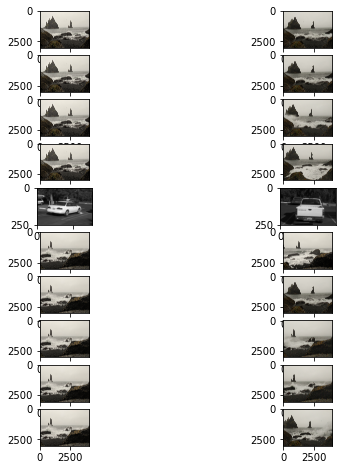

In [20]:
display_duplicates(batch_images,dups[:10],True)

In [12]:
def compare_images(images):
    sim_list = []
    for i in range(len(images)):
        s_i = []
        for j in range(i+1,len(images)):
            img1 = images[i]
            img2 = images[j]
            img1_shape = img1.shape
            img2_shape = img2.shape
            if img1_shape == img2_shape:
                color = True if img1_shape[2] > 1 else False
                sscore,_ = similarity(images[i],images[j],color)
                s_i.append((j,sscore))
        sim_list.append(s_i)
    return sim_list


from skimage.metrics import structural_similarity
def similarity(img1,img2, color=True, full=False):
    if full:
        mean_sim,diff_mat = structural_similarity(img1,img2,full=full, multichannel=color,gaussian_weights=True,sigma=1.5)
    else: 
        diff_mat = None
        mean_sim = structural_similarity(img1,img2,full=full, multichannel=color,gaussian_weights=True,sigma=1.5)
    return mean_sim,diff_mat

In [22]:
sscore, diff_mat = similarity(batch_images[13],batch_images[21])

In [19]:
batch_images_resized = resize_images(batch_images,(128,128))

In [33]:
sims = compare_images(batch_images_resized)

In [36]:
sscores = [t[1] for l in sims for t in l]

In [13]:
def threshold(sscores,std_devs = 3):
    sscores = np.array(sscores)
    mean_score = sscores.mean()
    std_score = sscores.std()
    return mean_score + std_devs*std_score

In [38]:
threshold(sscores)

0.46888682978197943

In [14]:
def duplicates(sims,threshold):
    dups = []
    for i in range(len(sims)):
        sim_i = sims[i]
        li = []
        for ind,score in sim_i:
            if score > threshold:
                li.append(ind)
        if li:
            li.append(i)
            dups.append(li)

    return dups


In [40]:
ds = duplicates(sims,threshold(sscores))

In [74]:
dus = []
for l in ds:
    if len(l) > 2:
        dus.append(l[:2])
    else:
        dus.append(l)

[[59, 2],
 [21, 57, 59, 3],
 [13, 27, 28, 34, 11],
 [27, 28, 34, 13],
 [35, 18],
 [57, 21],
 [28, 34, 41, 27],
 [34, 28],
 [44, 39],
 [54, 53],
 [59, 57]]

In [15]:
def combine_dups(duplicates):
    combined = []
    skip = []
    for i in range(len(duplicates)):
        if i not in skip:
            cur_combined = duplicates[i]
            for j in range(i+1, len(duplicates)):
                if any(item in cur_combined for item in duplicates[j]):
                    skip.append(j)
                    for k in range(len(duplicates[j])):
                        if duplicates[j][k] not in cur_combined:
                            cur_combined.append(duplicates[j][k])
                        
            combined.append(cur_combined)
    return combined

In [42]:
comb_dups = combine_dups(ds)

In [43]:
comb_dups

[[59, 2, 21, 57, 3], [13, 27, 28, 34, 11, 41], [35, 18], [44, 39], [54, 53]]

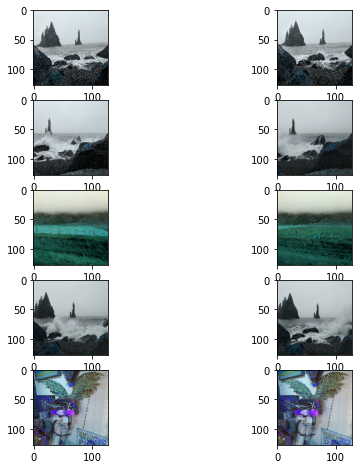

In [85]:
display_duplicates(batch_images_resized,comb_dups)

In [16]:
import imutils
def find_diff_portions(diff_mat):
    if diff_mat.dtype != np.uint8:
        diff_mat = np.uint8(diff_mat*255)
    thresh = cv2.threshold(diff,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
        

TypeError: 'int' object is not callable

In [17]:


def extract_orb_features(images):
    for image in images:
        if image.shape[2] > 1:
            cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        orb=cv2.ORB()
        keypoints = orb.detect(images,None)
        keypoints, descriptors = orb.compute(image,keypoints)
        return keypoints, descriptors
        
def feature_comparison(feature_vecs,):
    pass

In [ ]:
k,d = extract_orb_features(batch_images_resized[:3])

In [9]:
import shutil
import os
image_dir = '/Users/rickgentry/Spring 2021/computer_vision/final_project/data/PhotoSorter_images'
test_dir = '/Users/rickgentry/Spring 2021/computer_vision/final_project/data/test_data'
color_test_dir = '/Users/rickgentry/Spring 2021/computer_vision/final_project/data/color_test_data'
fnames = os.listdir('/Users/rickgentry/Spring 2021/computer_vision/final_project/data/PhotoSorter_images')
for fname in fnames:
    img_shape = cv2.imread(os.path.join(image_dir,fname)).shape
    if len(img_shape) == 3 and img_shape[2] == 3:
        shutil.copy(os.path.join(image_dir,fname),os.path.join(color_test_dir,fname))

## Neural Network

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing

# Dataset creation

data_dir = "/Users/rickgentry/Spring 2021/computer_vision/final_project/data"
color_test_dir = os.path.join(data_dir,"color_test_data")

filename_dataset = tf.data.Dataset.list_files(os.path.join(data_dir,test_dir,'*'))


In [41]:
filename_dataset

<ShuffleDataset shapes: (), types: tf.string>

In [18]:
BATCH_SIZE = 64
img_size = (224,224)
test_dataset = image_dataset_from_directory(color_test_dir,shuffle=False,label_mode=None, batch_size=BATCH_SIZE, image_size=img_size)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
img_shape = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,include_top=False,weights='imagenet')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Found 329 files belonging to 1 classes.


In [19]:
inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = base_model(x,training=False)
outputs = global_average_layer(x)
model = tf.keras.Model(inputs,outputs)


In [40]:
features = model.predict(filename_dataset,batch_size=64)

ValueError: in user code:

    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/rickgentry/opt/anaconda3/envs/imageflask/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer Conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=0. Full shape received: ()


In [21]:
features.shape

(329, 1280)

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
norm_features = normalize(features,axis=0)
km = KMeans(n_clusters=10).fit(norm_features)
km.labels_.shape

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 7, 7, 7, 7, 7, 8, 7, 7, 1, 9, 9, 9,
       9, 9, 9, 9, 1, 1, 1, 1, 2, 9, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 7, 5, 5, 5, 0, 5, 5, 0, 4, 4, 4, 7, 7, 7, 0, 0, 1,
       1, 1, 1, 8, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 8, 8, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 4, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,

In [42]:
km.n_clusters

10

AttributeError: 'BatchDataset' object has no attribute 'data'

In [36]:
np.where(km.labels_== 0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  13,  14,
         15,  18,  19,  20,  75,  78,  85,  86, 277, 278, 279, 282, 285,
        286, 291, 293, 295, 299, 304, 308, 316, 318, 325, 326, 327]),)